# Conversión de texto a recomendaciones. Optimización de sistema de recomendación mediante NLP y comprobación mediante web scrapping

Notebook Jupyter realzada por Carlos Rodriguez, contacto carlosd2.rodriguez@gmail.com https://github.com/carlosrosan/ACAMICA


## data_reviews: STEAM

**Origen de los datos de juegos y reviews [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

#### Objetivo: Mejorar un modelo de machine learning de Filtro Colaborativo para un sistema de recomendación de juegos, con métodos de NPL y fuentes de data complementarias mediante web scrapping.

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 7
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)
data_reviews.head(3)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,found_funny,compensation
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Sneaky_Panda,0.6,243.0,725280,3,2017-11-27,If you take a discount - it's not a bad horror...,False,1,NaN,NaN,NaN
2,Coby,8.9,227.0,35140,3,2018-01-03,Finished the game around 6 hours. Thats only t...,False,1,NaN,NaN,NaN


In [2]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [3]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


## Acerca de la predicción de la entrega anterior: Target metascore.

Hay limitaciones de Memoria RAM para el procesamiento del data_reviews. Con 16 GB RAM no fue posible para mi procesar el 100% del data_reviews de reviews, solo logré procesar el 70%.

Predecir recomendaciones mediante rating sirve para casos muy particulares y no es funcional todo el tiempo. Por ejemplo, si abro por primera vez una web de Ecommerce espero ver los productos mejor calificados, pero luego de filtrar de forma manual o buscar de forma repetitiva en la misma web, espero ver que las recomendaciones cada vez más se ajusten a mis parámetros de búsqueda.

Por lo cual, si bien tenía una expectativa de generar recomendaciones con data_reviewss de comportamiento de búsqueda, en realidad solo podemos hacer recomendaciones basadas en los productos de mejor rating.

Finalmente, creo que quizá sea necesario balancear el hecho que algunos usuarios aportan más datos que otros (califican más juegos, generan mas horas y metascore) mediante la sustracción del metascore medio del usuario de todas las calificaciones del mismo

## Propuestas a probar en esta entrega:

1 ) Usar el feature found funny y el texto de dejó el usuario al calificar, para mejorar el sistema de recomendación, usado librerías de procesamiento de lenguaje natural. Evitar el metascore y generar una métrica numérica de rating de cada review a partir del texto de la calificación. Depender del metascore es depender de una variable calculada por la plataforma y no generada por el usuario (no depende del data_reviews de revies ya que es un feature del juego). 

2 ) Considerar de igual manera en la ponderación la variable "found funny" ya que ella define si la calificación fue negativa o positiva. Solo usar el data_reviews de juegos para extraer el título y género.

3 ) data_reviews externo: web actual de Steam https://store.steampowered.com/ obtener nuevas reseñas para testear la predicción, inclusive usando mi cuenta personal de Steam para entender si las recomendaciones se alinean. Usar web scrapping con Selenium y Beautifullsoup.

# Objetivo del script:

Un script de python que genere recomendaciones basado en data más flexible en su origen (scrapping) y más relacionado a la review de cada usuario (texto de la review de cada uno). Esto no implica mejorar el performance del modelo como objetivo, pero si mejorar la adaptabilidad del mismo.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

C:\Users\Eric\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Análisis exploratorio de datos general

In [5]:
# Los 10 más populares

for i in range(0,9):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts().index[i])].title.values)

['Team Fortress 2']
['Rust']
['Borderlands 2']
['Fallout 4']
['Grand Theft Auto V']
['Undertale']
['Portal 2']
['DayZ']
['Warframe']


In [6]:
# Los 10 menos populares

for i in range(0,9):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts(ascending=True).index[i])].title.values)

['Fairy Tale About Father Frost, Ivan and Nastya']
['Grape Jelly']
['Catching Up']
["Delicious - Emily's Message in a Bottle"]
['Creature Factory 2']
['Squarism']
['Fish or Die']
['Defense Of Greece TD']
['The HinterLands']


#### Aplicaremos las transformaciones sobre el data_reviews, las mismas que realizamos sobre el trabajo anterior

In [7]:
# Eliminar valores faltantes de los IDs de productos (juegos) y usuarios

print(data_reviews.shape)
data_reviews.product_id = data_reviews.product_id.replace(['NA'],np.nan)
data_reviews = data_reviews[~data_reviews.product_id.isna()]
data_reviews = data_reviews[~data_reviews.user_id.isna()]
print(data_reviews.shape)

(1113296, 12)
(452948, 12)


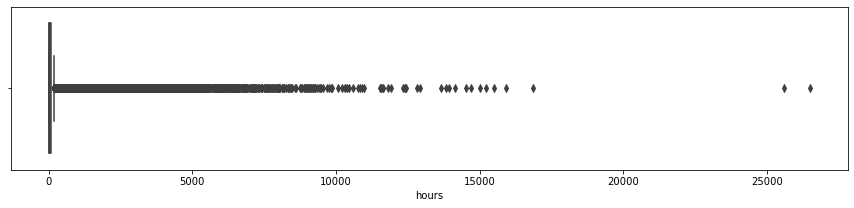

In [8]:
#Gráfico de horas jugadas por usuario por juego

plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

count    451849.000000
mean        121.265491
std         390.463281
min           0.000000
25%           4.800000
50%          18.700000
75%          74.000000
max       26478.600000
Name: hours, dtype: float64


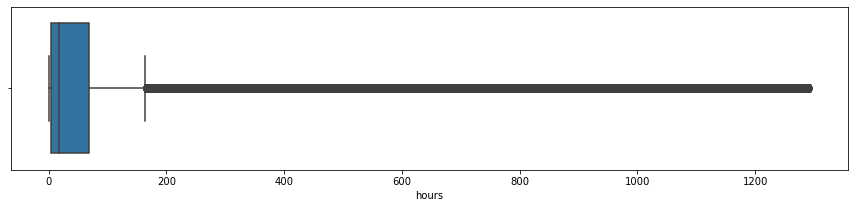

In [9]:
# Existen juegos y usuarios con cantidades de horas jugadas que pueden considerarse como outliers, las cuales eliminaremos.

print(data_reviews['hours'].describe())

valor_medio = data_reviews['hours'].mean()
std = data_reviews['hours'].std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data_reviews['hours'] < minimo, data_reviews['hours'] > maximo)

data_reviews = data_reviews[~mascara_outliers]

plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

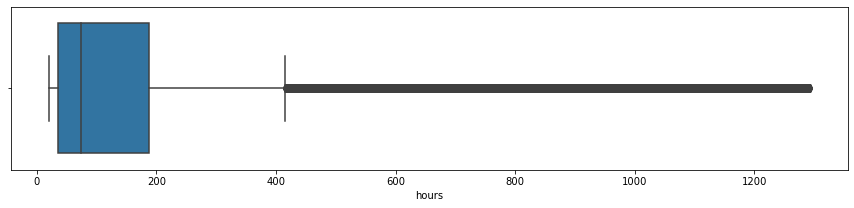

In [10]:
# Filtraremos los juegos jugados por más de 2 usuarios y por mas de 20 horas por usuario

data_reviews = data_reviews[data_reviews['hours'] >= 20]
plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

In [11]:
# Eliminaremos los juegos con pocos reviews (menos de 2)

print(data_reviews.shape)
data_reviews = data_reviews.groupby('user_id').filter(lambda x: len(x) >= 2)
data_reviews.user_id.value_counts()
print(data_reviews.shape)

(212142, 12)
(44957, 12)


In [12]:
data_games = data_games.rename(columns={'id':'product_id'})
data_reviews = data_reviews.merge(data_games, on='product_id', how='left')

# Transformaremos los tipos de datos

data_reviews.metascore = data_reviews.metascore.replace(['NA'],np.nan)
data_reviews.metascore = data_reviews.metascore.astype(np.float32)
data_reviews.product_id = data_reviews.product_id.astype(int) 

# Eliminaremos los valores faltatentes, excepto found funny que parece tener un significado (sustituiremos por 0)

print(data_reviews.shape)
data_reviews = data_reviews[~data_reviews.text.isna()]

data_reviews.found_funny = data_reviews.found_funny.fillna(0)

data_games = data_games[~data_games.product_id.isna()]
data_games = data_games[~data_games.title.isna()]
data_games.product_id = data_games.product_id.astype(int)
print(data_reviews.shape)

data_reviews = data_reviews.drop(columns=['products','page_order','date','early_access_x','page','compensation','publisher','app_name','url','release_date','tags','discount_price','reviews_url','specs','early_access_y','developer','sentiment'])
data_reviews.head(3)

(44987, 27)
(44987, 27)


,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore
0,Kevin Droid,21.6,35140,A great game of its time. Near the end of the ...,76561198030870442,0.0,"[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,19.99,91.0
1,tanelorn,145.2,344340,This game is frustrating as hell. As much as ...,76561197972369732,3.0,"[Indie, Simulation, Sports, Strategy]",Front Office Football Seven,18.99,NaN
2,Strayed Lynx,29.5,745880,The latest game from the legandary Touhou seri...,76561198160868511,2.0,[Indie],東方天空璋 ～ Hidden Star in Four Seasons.,14.99,NaN


#### Análisis exploratorio de datos de los nuevos targets: found_funny y text

In [13]:
data_reviews.found_funny.value_counts()

0.0      38933
1.0       3720
2.0        953
3.0        372
4.0        225
         ...  
292.0        1
112.0        1
76.0         1
82.0         1
284.0        1
Name: found_funny, Length: 119, dtype: int64

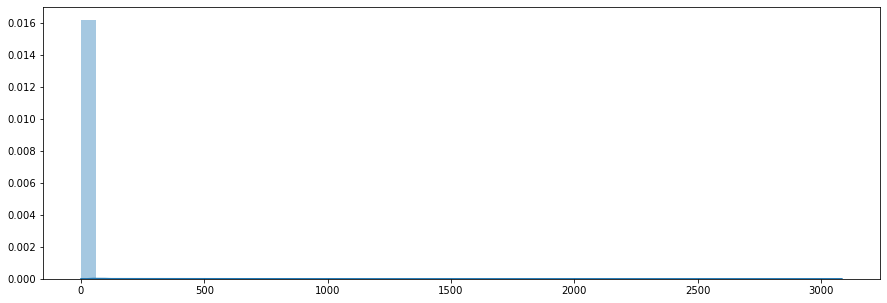

In [14]:
plt.subplots(figsize=(15,5))
sns.distplot(data_reviews.found_funny.astype(int).values)

## Notamos que los valores de la columna found_funny están muy sesgados hacia el cero. Esto tiene sentido asumiendo que presenta la cantidad de veces que se le ha otorgado review positiva por cada usuario 

0.7607308778091448 18.551018223656293 -54.89232379315973 56.41378554877802


Text(0, 0.5, 'Frecuencia por bins')

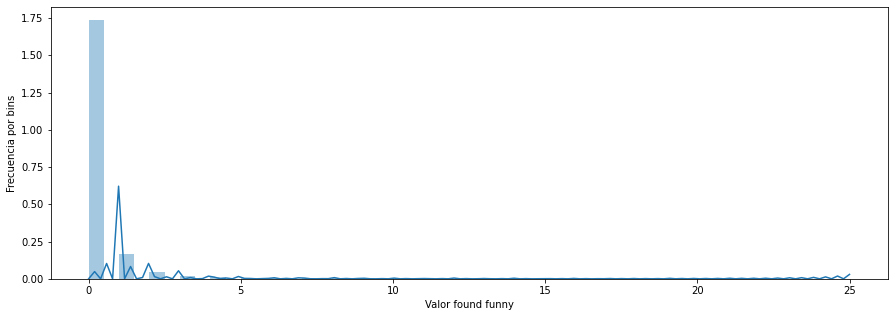

In [15]:
# Eliminaremos los outliers del feature found_funny

valor_medio = data_reviews.found_funny.mean()
std = data_reviews.found_funny.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std

mascara_outliers = data_reviews.found_funny < maximo
print(valor_medio, std, minimo, maximo)

data_reviews = data_reviews[mascara_outliers]
data_reviews = data_reviews[data_reviews.found_funny<=25]
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(data_reviews.found_funny)
ax.set_xlabel('Valor found funny')
ax.set_ylabel('Frecuencia por bins')

### Esta será la nueva distribución de found_funny

In [16]:
print(data_reviews.shape)
data_reviews.found_funny.value_counts()

(44829, 10)


0.0     38933
1.0      3720
2.0       953
3.0       372
4.0       225
5.0       138
7.0        86
6.0        74
8.0        67
9.0        42
10.0       26
12.0       23
19.0       21
11.0       19
14.0       19
13.0       17
17.0       16
15.0       16
16.0       13
21.0       10
25.0        8
22.0        7
20.0        6
18.0        6
23.0        6
24.0        6
Name: found_funny, dtype: int64

In [17]:
data_reviews.text.value_counts()[0:10]

                  84
good game         50
Great game        43
good              42
Good game         40
.                 35
great game        33
10/10             33
yes               26
best game ever    25
Name: text, dtype: int64

In [18]:
print(len(data_reviews.text))
data_reviews = data_reviews[data_reviews.text != '']
data_reviews = data_reviews[data_reviews.text != ' ']
print(len(data_reviews.text))

44829
44745


In [19]:
data_reviews[data_reviews.text.str.contains('batman')].head(3)

,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore
37,nebula,32.9,35140,"Despite of the network disconnect error, this ...",76561198368074931,0.0,"[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,19.99,91.0
116,indominusjack13,33.9,35140,i love this game i play on my xbox and PC it h...,76561198331467067,1.0,"[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,19.99,91.0
347,=T$E= Volkov-V2.5,21.9,35140,Even tough it took me ages to get this game as...,76561198027504943,0.0,"[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,19.99,91.0


In [20]:
data_reviews.text = data_reviews.text.str.lower()

In [21]:
from collections import Counter 
import statistics 
from statistics import mode 

mas_comunes = [item for t in Counter(" ".join(data_reviews.text).split()).most_common(100) for item in t]
mas_comunes = [x for x in mas_comunes if not isinstance(x, int)]
mas_comunes[0:10]

['the', 'and', 'to', 'a', 'of', 'is', 'i', 'you', 'game', 'it']

In [22]:
def letter(word_list, k):
    words = []
    for word in word_list:
        if len(word)>k:
            words.append(word)
    return words

letter(mas_comunes, 4)

['game.',
 'there',
 'really',
 'great',
 'would',
 'games',
 'game,',
 'still',
 'about',
 'which',
 'other',
 'because',
 "don't",
 'first',
 'story',
 'playing',
 'played',
 'after',
 'hours',
 'people']

### Podemos observar las palabras más frecuentes, y cuales pueden relacionarse con la satisfacción del juego. 

### Todavía no estamos 100% seguros que found funny es el feature indicado para ser Target del sistema de recomendación.

### La propuesta que hago es usar NLP para validar relacion entre found funny y el texto de review, y si lo es (Es decir, es posible predecir el found funny en función del texto) entonces found funny será un target adecuado dependiende del review individual de cada usuario.

### Con ese nuevo "target" entrenar el sistema de recomendación de la Entrega 3 como nuevo Target, y comparar recomendaciones individuales.


In [23]:
import itertools

sns.set()

import nltk

from nltk.corpus import stopwords

# Esto sirve para configurar NLTK. La primera vez puede tardar un poco

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# 1 solo review
index_random = np.random.randint(0,high = data_reviews.shape[0])
review = data_reviews.iloc[index_random].text
print(index_random, review)

23000 very good game, you will have alot of fun playing this... it just needs more stuff adding to it, and when they do add more stuff i'll play it alot more. well worth the money they asking for


In [25]:
review_st = nltk.tokenize.sent_tokenize(review)
review_st

["very good game, you will have alot of fun playing this... it just needs more stuff adding to it, and when they do add more stuff i'll play it alot more.",
 'well worth the money they asking for']

In [26]:
review_wt = nltk.tokenize.word_tokenize(review)
review_wt[0:10]

['very', 'good', 'game', ',', 'you', 'will', 'have', 'alot', 'of', 'fun']

In [27]:
stop_words = set(stopwords.words("english"))
for w in review_st:
    if w not in stop_words:
        pass # Do something.

for palabra in stop_words:
    break

In [28]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [29]:
review_wt_sin_sw = [word for word in review_wt if word not in stopwords]
review_wt_sin_sw[0:10]

['good',
 'game',
 ',',
 'alot',
 'fun',
 'playing',
 '...',
 'needs',
 'stuff',
 'adding']

In [30]:
freq = nltk.FreqDist(review_wt_sin_sw)
freq

FreqDist({',': 2, 'alot': 2, 'stuff': 2, 'good': 1, 'game': 1, 'fun': 1, 'playing': 1, '...': 1, 'needs': 1, 'adding': 1, ...})

In [31]:
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

# data_reviews Completo

data_reviews_text = []
for i in range(data_reviews.shape[0]):
    review = data_reviews.iloc[i].text
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords]
    review = [word for word in review if word not in filtrar]

    data_reviews_text.append(review)

In [32]:
data_reviews.found_funny.describe()

count    44745.000000
mean         0.306090
std          1.386167
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.000000
Name: found_funny, dtype: float64

In [33]:
data_reviews.head(3)

,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore
0,Kevin Droid,21.6,35140,a great game of its time. near the end of the ...,76561198030870442,0.0,"[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,19.99,91.0
1,tanelorn,145.2,344340,this game is frustrating as hell. as much as ...,76561197972369732,3.0,"[Indie, Simulation, Sports, Strategy]",Front Office Football Seven,18.99,NaN
2,Strayed Lynx,29.5,745880,the latest game from the legandary touhou seri...,76561198160868511,2.0,[Indie],東方天空璋 ～ Hidden Star in Four Seasons.,14.99,NaN


In [34]:
data_reviews_text[0]

['great',
 'game',
 'time',
 'near',
 'end',
 'game',
 'suddenly',
 'realized',
 'playing',
 'action',
 'version',
 'bioshock',
 'everything',
 'looks',
 'nice',
 'familiar',
 'borderless',
 'fullscreen',
 'fixed',
 'gedosato',
 'ease',
 'story',
 'ok',
 'things',
 'drew',
 'collectibles',
 'sidestories',
 'tapes',
 'quite',
 'lot',
 'depth',
 'voice',
 'actings',
 'brilliant',
 'game',
 'time',
 'back',
 'tracking',
 'real',
 'fun',
 'nonetheless']

In [35]:
list(itertools.chain('ABC', 'DEF'))

['A', 'B', 'C', 'D', 'E', 'F']

In [36]:
data_reviews_text = list(itertools.chain(*data_reviews_text))
data_reviews_text[0:10]

['great',
 'game',
 'time',
 'near',
 'end',
 'game',
 'suddenly',
 'realized',
 'playing',
 'action']

In [37]:
freq_data_reviews_text = nltk.FreqDist(data_reviews_text)
freq_data_reviews_text

FreqDist({'game': 81910, 'not': 20347, 'like': 18908, 'good': 13968, 'one': 13870, 'get': 13859, 'play': 12984, 'fun': 12263, 'time': 10801, 'great': 10768, ...})

In [38]:
df_freq_reviews_text = pd.DataFrame(list(freq_data_reviews_text.items()), columns = ["Word","Frequency"])
df_freq_reviews_text.head()

,Word,Frequency
0,great,10768
1,game,81910
2,time,10801
3,near,467
4,end,2521


In [39]:
df_freq_reviews_text.sort_values('Frequency',ascending=False, inplace = True)
df_freq_reviews_text.head()

,Word,Frequency
1,game,81910
97,not,20347
42,like,18908
133,good,13968
90,one,13870


In [40]:
df_freq_reviews_text.reset_index(drop = True, inplace=True)
df_freq_reviews_text.head()

,Word,Frequency
0,game,81910
1,not,20347
2,like,18908
3,good,13968
4,one,13870


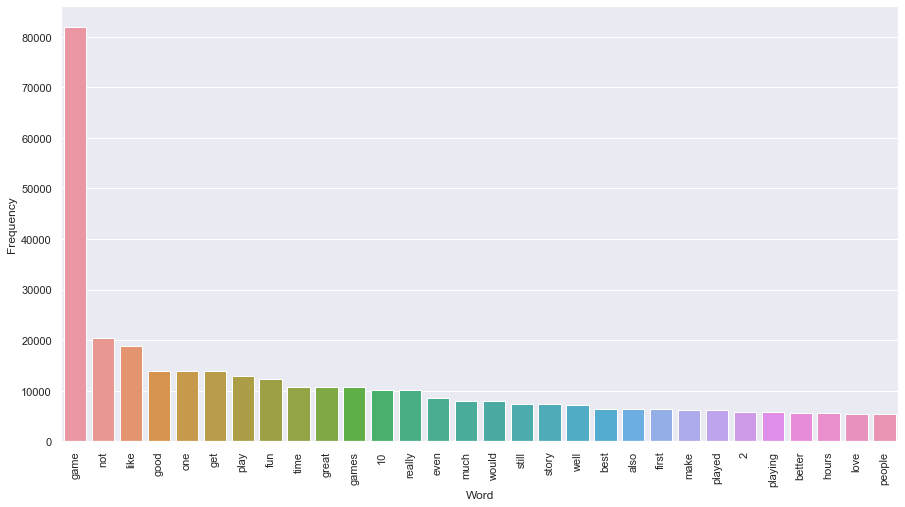

In [41]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_freq_reviews_text.iloc[:30].Word, y = df_freq_reviews_text.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

# Palabras mas frecuentes en los textos de reviews de data_reviews

In [42]:
# Importamos esta libreria que nos permite reemplzar caracteres

import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Traemos nuevamente las stopwords

stopwords = nltk.corpus.stopwords.words('english')

In [43]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno

review_list=[]
for review in data_reviews.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del review
    review=nltk.word_tokenize(review)
    # Eliminamos las palabras de menos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[stemmer.stem(palabra) for palabra in review]
    # Por ultimo volvemos a unir el review
    review=" ".join(review)
    
    # Vamos armando una lista con todos los reviewes
    review_list.append(review)
    #data_reviews["review_normalizado"] = review_list


In [44]:
data_reviews["review_stem"] = review_list
data_reviews.tail()

,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore,review_stem
44982,alex_matey,83.3,252490,basicly get chased by naked guy with rock / ho...,76561198064019717,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,basicli chase nake rock hour
44983,ForsakenSage,192.3,252490,simply amazing. its everything i wished dayz w...,76561198055986454,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,simpli amaz everyth wish dayz must
44984,ForsakenSage,192.3,252490,simply amazing. its everything i wished dayz w...,76561198055986454,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,simpli amaz everyth wish dayz must
44985,Lordpinecone,100.5,252490,10/10,76561198067964166,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,
44986,General Bud,507.2,252490,"fun game full of naked men, zombies, and anima...",76561198068325674,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,game full nake zombi anim


In [45]:
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

# data_reviews Completo

data_reviews_review_stem = []
for i in range(data_reviews.shape[0]):
    review = data_reviews.iloc[i].review_stem
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords]
    review = [word for word in review if word not in filtrar]

    data_reviews_review_stem.append(review)

In [46]:
type(data_reviews_review_stem)

list

In [47]:
len(data_reviews_review_stem)

44745

In [48]:
data_reviews_review_stem[0]

['great',
 'game',
 'time',
 'near',
 'game',
 'suddenli',
 'realiz',
 'play',
 'action',
 'version',
 'bioshock',
 'everyth',
 'look',
 'nice',
 'familiar',
 'borderless',
 'fullscreen',
 'fix',
 'gedosato',
 'eas',
 'stori',
 'thing',
 'drew',
 'collect',
 'sidestori',
 'tape',
 'quit',
 'depth',
 'voic',
 'act',
 'brilliant',
 'game',
 'time',
 'back',
 'track',
 'real',
 'nonetheless']

In [49]:
list(itertools.chain('ABC', 'DEF')) 

['A', 'B', 'C', 'D', 'E', 'F']

In [50]:
data_reviews_review_stem = list(itertools.chain(*data_reviews_review_stem))
data_reviews_review_stem[0:10]

['great',
 'game',
 'time',
 'near',
 'game',
 'suddenli',
 'realiz',
 'play',
 'action',
 'version']

In [51]:
freq_data_reviews_review_stem = nltk.FreqDist(data_reviews_review_stem)
freq_data_reviews_review_stem

FreqDist({'game': 93387, 'play': 25611, 'like': 20672, 'good': 14145, 'time': 13808, 'great': 10830, 'make': 10676, 'realli': 10077, 'even': 8675, 'much': 7957, ...})

In [52]:
df_freq_reviews_review_stem = pd.DataFrame(list(freq_data_reviews_review_stem.items()), columns = ["Word","Frequency"])
df_freq_reviews_review_stem.head()

,Word,Frequency
0,great,10830
1,game,93387
2,time,13808
3,near,487
4,suddenli,222


In [53]:
df_freq_reviews_review_stem.sort_values('Frequency',ascending=False, inplace = True)
df_freq_reviews_review_stem.head()

,Word,Frequency
1,game,93387
6,play,25611
37,like,20672
108,good,14145
2,time,13808


In [54]:
df_freq_reviews_review_stem.reset_index(drop = True, inplace=True)
df_freq_reviews_review_stem.head()

,Word,Frequency
0,game,93387
1,play,25611
2,like,20672
3,good,14145
4,time,13808


#### Top 30 palabras CON "Steming"

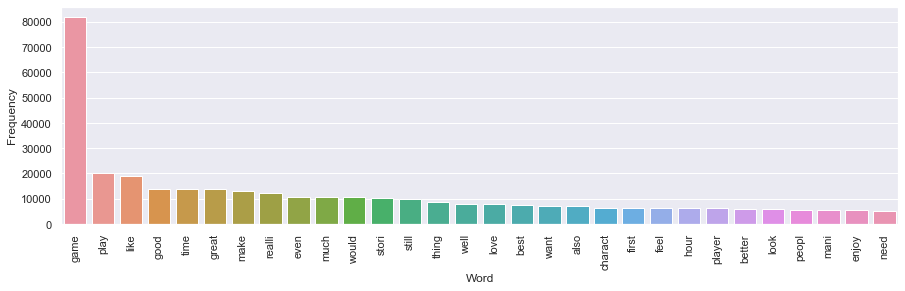

In [55]:
plt.figure(figsize = (15,4))
plot = sns.barplot(x  = df_freq_reviews_review_stem.iloc[:30].Word, y = df_freq_reviews_text.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

#### vs Top 30 palabras SIN "Steming"

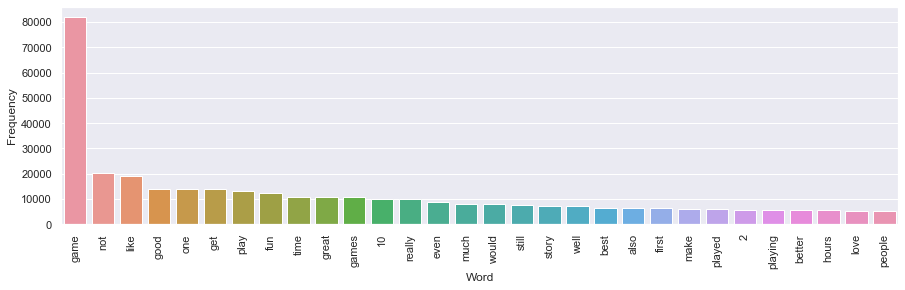

In [56]:
plt.figure(figsize = (15,4))
plot = sns.barplot(x  = df_freq_reviews_text.iloc[:30].Word, y = df_freq_reviews_text.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

## Vale la pena mientras, validar también la correlación entre el found_funny y el metascore. Si están altamente correlacionados quiere decir que el found funny es una medida viable de satisfacción

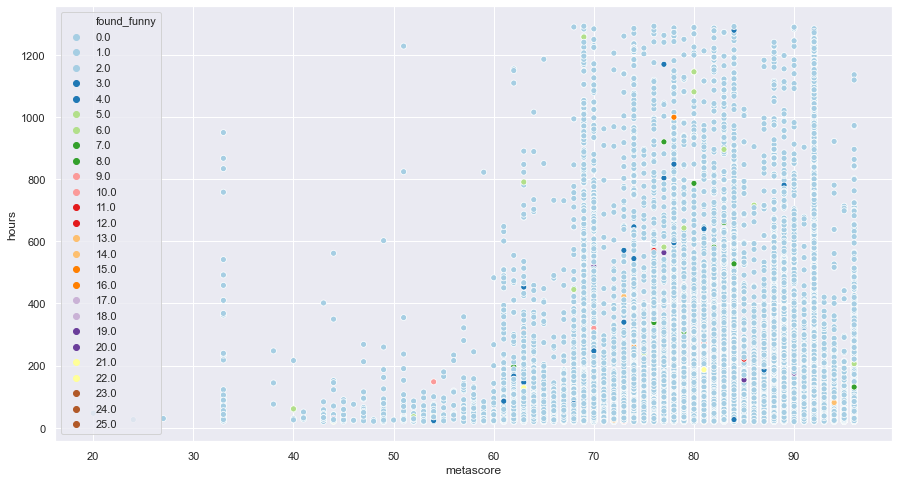

In [57]:
fig, ax = plt.subplots(figsize=(15,8))
ax= sns.scatterplot(x="metascore", y="hours", hue='found_funny', data=data_reviews, palette='Paired', legend='full')
plt.show()

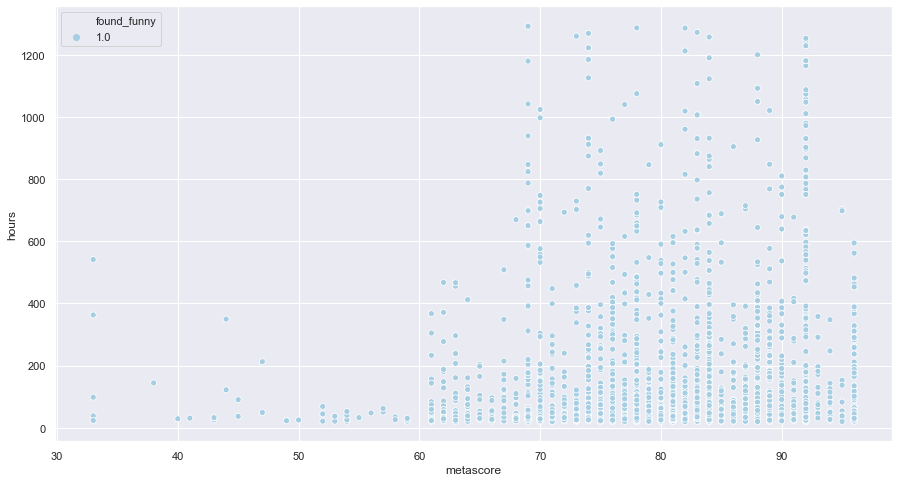

In [58]:
data_reviews_foundf_1 = data_reviews[data_reviews.found_funny==1]

fig, ax = plt.subplots(figsize=(15,8))
ax= sns.scatterplot(x="metascore", y="hours", hue='found_funny', data=data_reviews_foundf_1, palette='Paired', legend='full')
plt.show()

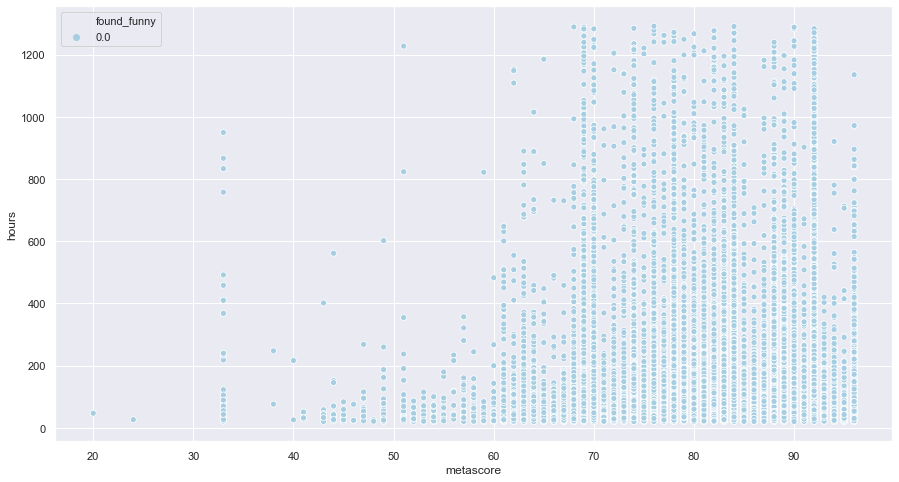

In [59]:
data_reviews_foundf_0 = data_reviews[data_reviews.found_funny==0]

fig, ax = plt.subplots(figsize=(15,8))
ax= sns.scatterplot(x="metascore", y="hours", hue='found_funny', data=data_reviews_foundf_0, palette='Paired', legend='full')
plt.show()

## Propuesta simplificadora: Usar solo los valores de found Funny 1 y 0, entrenar un algoritmo con ellos y así demostrar que el hay una relación entre el texto de review negativo y 0, y entre el texto positivo y 1

In [60]:
mascara_found_funny = np.logical_or(data_reviews['found_funny'] == 0, data_reviews['found_funny'] == 1)
data_reviews_nlp = data_reviews[mascara_found_funny]

### Lemmatizacion

In [62]:
# Importamos el lemmatizar de NLTK, y creamos el objeto

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [63]:
# Oracion que usaremos como ejemplo

frase = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."

# Hay que regularizar el texto. Dejar solo letra, pasar a minúsculas y tokenizar:

# Sacamos todo lo que no sean letras
frase = re.sub("[^a-zA-Z]"," ",str(frase))
# Pasamos a minúsculas
frase = frase.lower()
# Tokenizamos
frase_tokens = nltk.word_tokenize(frase)

# Veamos como cambians las palabras al lemmatizar

print("{0:20}{1:20}".format("Word","Lemma"))
for palabra in frase_tokens:
    print ("{0:20}{1:20}".format(palabra,wordnet_lemmatizer.lemmatize(palabra)))

Word                Lemma               
he                  he                  
was                 wa                  
running             running             
and                 and                 
eating              eating              
at                  at                  
same                same                
time                time                
he                  he                  
has                 ha                  
bad                 bad                 
habit               habit               
of                  of                  
swimming            swimming            
after               after               
playing             playing             
long                long                
hours               hour                
in                  in                  
the                 the                 
sun                 sun                 


In [64]:
import nltk
nltk.download('averaged_perceptron_tagger')

print(nltk.pos_tag(frase_tokens))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('he', 'PRP'), ('was', 'VBD'), ('running', 'VBG'), ('and', 'CC'), ('eating', 'VBG'), ('at', 'IN'), ('same', 'JJ'), ('time', 'NN'), ('he', 'PRP'), ('has', 'VBZ'), ('bad', 'JJ'), ('habit', 'NN'), ('of', 'IN'), ('swimming', 'NN'), ('after', 'IN'), ('playing', 'VBG'), ('long', 'JJ'), ('hours', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('sun', 'NN')]


In [65]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [66]:
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(frase)]
tipo_palabra = [get_wordnet_pos(w) for w in nltk.word_tokenize(frase)]

# Veamos como cambiaron las palabras

print("{0:20}{1:20}{2:20}".format("Palabra:","Tipo:","Lemma:"))
for i in range(len(frase_tokens)):
    print ("{0:20}{1:20}{2:20}".format(frase_tokens[i],tipo_palabra[i],frase_lemma[i]))

Palabra:            Tipo:               Lemma:              
he                  n                   he                  
was                 v                   be                  
running             v                   run                 
and                 n                   and                 
eating              v                   eat                 
at                  n                   at                  
same                a                   same                
time                n                   time                
he                  n                   he                  
has                 v                   have                
bad                 a                   bad                 
habit               n                   habit               
of                  n                   of                  
swimming            v                   swim                
after               n                   after               
playing             v   

In [68]:
wordnet_lemmatizer = WordNetLemmatizer()

data_reviews_nlp=data_reviews_nlp[['text','found_funny']]
data_reviews_nlp.dropna(axis=0,inplace=True)

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [69]:
review_list=[]
for review in data_reviews_nlp.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras
    review=nltk.word_tokenize(review)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in review]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el review
    review=" ".join(review)
    review_list.append(review)
    
data_reviews_nlp["review_lemm"] = review_list
data_reviews_nlp.tail()

,text,found_funny,review_lemm
44982,basicly get chased by naked guy with rock / ho...,0.0,basicly chased naked rock hours
44983,simply amazing. its everything i wished dayz w...,0.0,simply amazing everything wished dayz must
44984,simply amazing. its everything i wished dayz w...,0.0,simply amazing everything wished dayz must
44985,10/10,0.0,
44986,"fun game full of naked men, zombies, and anima...",0.0,game full naked zombies animals


In [70]:
data_reviews_lemm = pd.concat([data_reviews_nlp.review_lemm,data_reviews_nlp.found_funny],axis=1)
data_reviews_lemm.head()

,review_lemm,found_funny
0,great game time near game suddenly realized pl...,0.0
3,last scene monkey business made fell trevor po...,0.0
4,battle chef brigade plays like timed match gam...,0.0
5,sitting inventory ages around playing couple b...,1.0
6,main reason recommend game steam version buggy...,0.0


#### Vectorizar

In [71]:
# Tomamso la lista de palabras y el vector que nos dice que valor de found funny tiene el review

list_reviews = list(data_reviews_lemm['review_lemm'].values)
found_fun = data_reviews_lemm['found_funny'].values

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz_reviews = cou_vec.fit_transform(list_reviews)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 primeras palabras mas usadas: ",all_words[0:50])

50 primeras palabras mas usadas:  ['abilities', 'ability', 'able', 'absolutely', 'access', 'account', 'achievements', 'across', 'acting', 'action', 'active', 'actual', 'actually', 'added', 'addicting', 'addictive', 'adding', 'addition', 'adds', 'adventure', 'ahead', 'alien', 'aliens', 'alive', 'allow', 'allows', 'almost', 'alone', 'along', 'alot', 'alpha', 'already', 'also', 'although', 'always', 'amazing', 'ammo', 'amount', 'animations', 'annoying', 'another', 'anymore', 'anyone', 'anything', 'anyway', 'apart', 'area', 'areas', 'arma', 'armor']


## Modelado del algoritmo de NLP

In [72]:
x = matriz_reviews.toarray()
y = found_fun

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["not funny","funny"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

#### Modelo Naive Bayes

In [73]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.7755725190839695


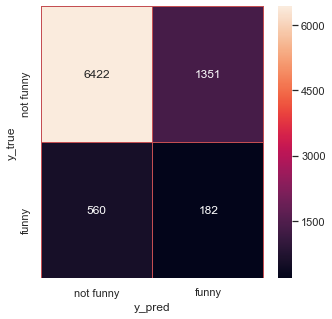

In [74]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.9208455666470934


## Accuracy Alto

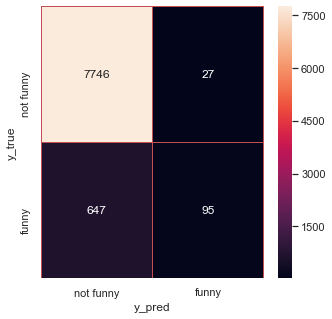

In [76]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

In [77]:
data_reviews_nlp.found_funny.value_counts()

0.0    38864
1.0     3708
Name: found_funny, dtype: int64

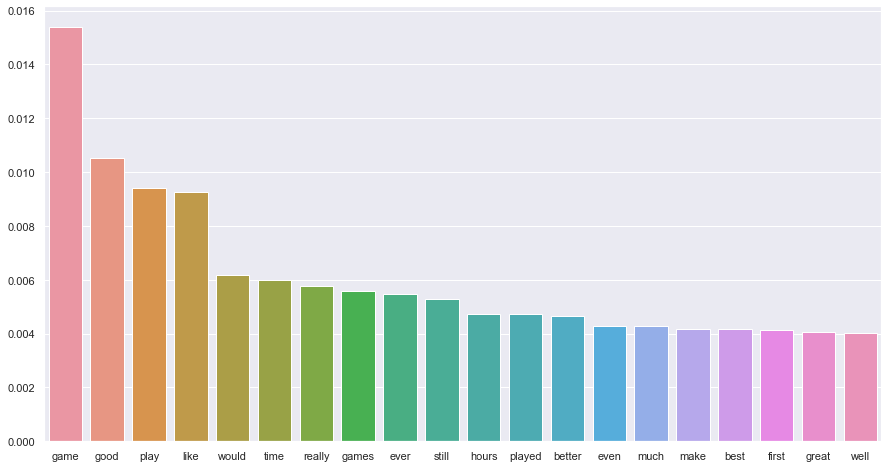

In [78]:
# Le preguntamos la importancia de cada feature (cada palabra)

importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

## Estas serían las palabras más relevantes durante el entrenamiento del modelo

## Probemos ahora con found funny entre 0 y 25.

In [79]:
data_reviews_nlp = data_reviews.copy()

data_reviews_nlp=data_reviews_nlp[['text','found_funny']]
data_reviews_nlp.dropna(axis=0,inplace=True)

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')

review_list=[]
for review in data_reviews_nlp.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras
    review=nltk.word_tokenize(review)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in review]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el review
    review=" ".join(review)
    #data_reviews["review_normalizado"] = review_list
    review_list.append(review)
    
data_reviews_nlp["review_lemm"] = review_list

data_reviews_lemm = pd.concat([data_reviews_nlp.review_lemm, data_reviews_nlp.found_funny], axis=1)

# Tomamso la lista de palabras y el vector que nos dice que valor de found funny tiene el review
list_reviews = list(data_reviews_lemm['review_lemm'].values)
found_fun = data_reviews_lemm['found_funny'].values

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz_reviews = cou_vec.fit_transform(list_reviews)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
#print("50 primeras palabras mas usadas: ",all_words[0:50])

X = matriz_reviews.toarray()
y = found_fun

print(len(X))
print(len(y))

44745
44745


In [80]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [81]:
rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.8746759631715384


## El Accuracy sigue siendo relativamente alto incluso con valores de found funny en un rango más ámplio

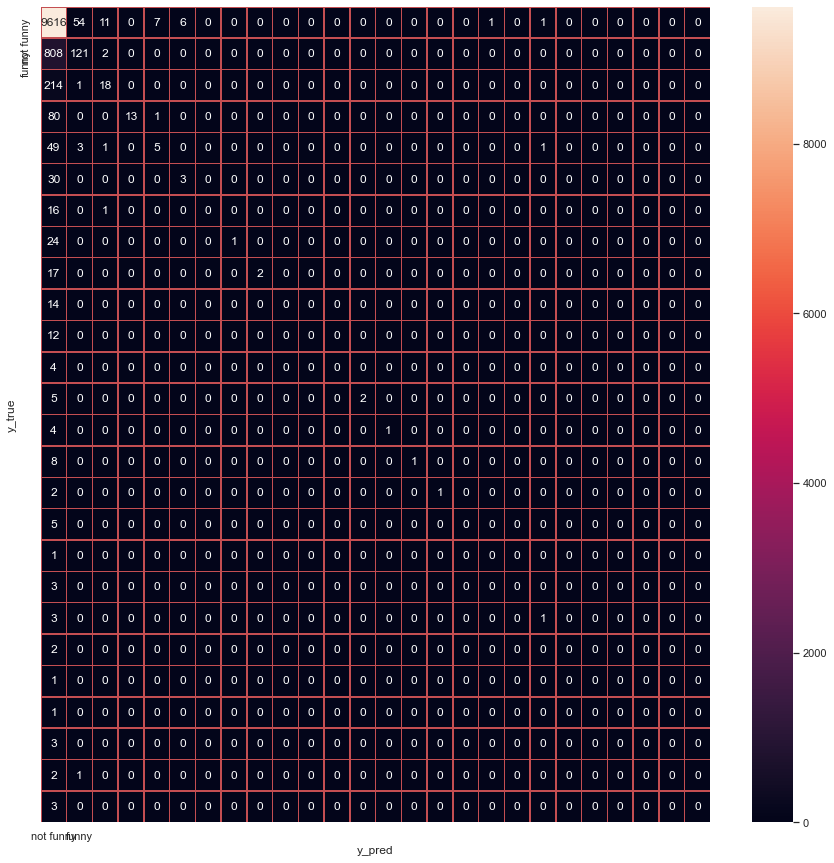

In [82]:
def confusion(ytest,y_pred):
    names=["not funny","funny"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(15,15))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

In [83]:
data_reviews_nlp.found_funny.value_counts()

0.0     38864
1.0      3708
2.0       951
3.0       372
4.0       225
5.0       137
7.0        86
6.0        74
8.0        67
9.0        42
10.0       26
12.0       23
19.0       21
11.0       19
14.0       19
13.0       17
17.0       16
15.0       16
16.0       13
21.0       10
25.0        8
22.0        7
20.0        6
18.0        6
23.0        6
24.0        6
Name: found_funny, dtype: int64

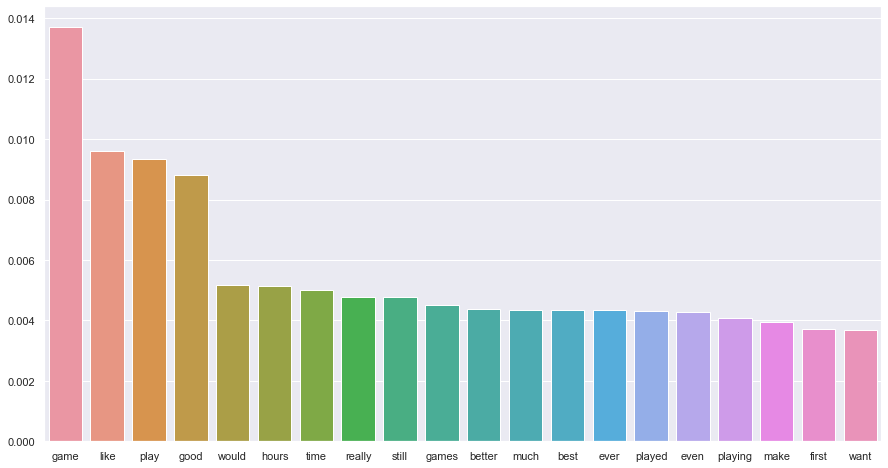

In [84]:
# Le preguntamos la importancia de cada feature (cada palabra)

importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

### Estas palabras son muy similares a las del entrenamiento del modelo de found funny binario

## Queda demostrado que found funny es una medida de calificación del juego individual, que depende de cada review usuario y por lo tanto puede usarse para entrenar recomendaciones.

In [85]:
!pip install surprise

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import SVD

In [86]:
df1 = data_reviews.copy()
df1 = df1.drop(['username','hours','text','metascore','genres','title','title','price','review_stem'], axis=1)
df1.head(3)

,product_id,user_id,found_funny
0,35140,76561198030870442,0.0
1,344340,76561197972369732,3.0
2,745880,76561198160868511,2.0


In [87]:
reader = Reader(rating_scale=(0, 25))
data = Dataset.load_from_df(df1[['user_id', 'product_id', 'found_funny']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.002)
algo.fit(trainset)
predictions = algo.test(testset)

In [88]:
usuario = 76561198011965365
df_user = df1[(df1['user_id'] == usuario) & (df1['found_funny'] > 0)]
df_user = df_user.reset_index(drop=True)

recomendaciones_usuario = data_games[['title','product_id']].iloc[:4499].copy()
recomendaciones_usuario.index = recomendaciones_usuario.product_id
recomendaciones_usuario = recomendaciones_usuario.drop(['product_id'], axis=1)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
772540,Battle Royale Trainer


In [89]:
usuario_vistas = df1[['user_id', 'product_id', 'found_funny']][df1['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(0, 3)


,user_id,product_id,found_funny


In [90]:
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,772540,Battle Royale Trainer


In [91]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,product_id,title,Estimate_Score
1085,209670,Cortex Command,2.427798
2089,293960,Spice Road,2.233554
3410,355840,Survarium,2.181678
3689,371420,Teddy Floppy Ear - The Race,1.828063
732,9350,Supreme Commander,1.767377
101,12510,Prison Tycoon 3™: Lockdown,1.726532
641,57900,Duke Nukem Forever,1.581101
1783,259530,Savant - Ascent,1.557304
1408,231740,Knights of Pen and Paper +1 Edition,1.487975
283,38410,Fallout 2: A Post Nuclear Role Playing Game,1.469731


In [92]:
rmse_found_funny = accuracy.rmse(predictions)

accuracy.rmse(predictions)

RMSE: 1.2774
RMSE: 1.2774


1.2774223662616566

### Como benchmark, realizaremos el entrenamiento usando como tarnet Metascore

In [113]:
# Factores extraidos de optimización en proyecto anterior: https://github.com/carlosrosan/ACAMICA/blob/main/DS_Proyecto_03_SR.ipynb

df1 = data_reviews.copy()
df1 = df1.drop(['username','hours','text','found_funny','genres','title','title','price','review_stem'], axis=1)
print(df1.shape)
df1 = df1.dropna()
print(df1.shape)

reader = Reader(rating_scale=(1, 100))
data = Dataset.load_from_df(df1[['user_id', 'product_id', 'metascore']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.002)
algo.fit(trainset)
predictions = algo.test(testset)

(44745, 3)
(30864, 3)


In [114]:
rmse_metascore = accuracy.rmse(predictions)

accuracy.rmse(predictions)

RMSE: 3.7294
RMSE: 3.7294


3.7294461416632925

### Comparando gráficamente los resultados de error entre todos los modelos entrenados

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

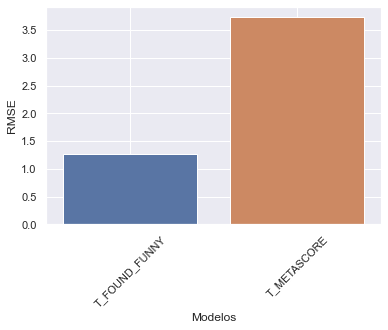

In [118]:
errores = {
    'Modelos': ['T_FOUND_FUNNY', 'T_METASCORE'],
    
    'RMSE': [rmse_found_funny, rmse_metascore]}

tabla_errores = pd.DataFrame(errores, columns = ['Modelos', 'RMSE'])

sns.barplot(x = 'Modelos', y = 'RMSE', data = tabla_errores)
plt.grid('y')
plt.xticks(rotation = 45)

## Misión cumplida!

## Hay una mejora considerable de este modelo usando found_funny como target, en comparación a cuando se usa metascore.


## Ahora vamos a scrappear alguna review nueva y recomendarle juegos según este modelo de buen performance, siempre que el nuevo juego esté contenido en dataset actual

In [102]:
game_to_scrap_from_reviews = 440# Acá agregar el product id del juego que deseemos buscar su última review de steam

game_to_scrap_from_reviews = str(game_to_scrap_from_reviews)

In [103]:
from bs4 import BeautifulSoup
import requests

url="https://steamcommunity.com/app/"+game_to_scrap_from_reviews+"/negativereviews/?browsefilter=toprated&snr=1_5_100010_&filterLanguage=english"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

links = []
for link in soup.find_all('a'):
    links.append(link.get('href'))

matching = [s for s in links if "profiles" in s]
matching[0]

'https://steamcommunity.com/profiles/76561198062578952/'

In [104]:
matching[0].strip('https://steamcommunity.com/profiles/')

'76561198062578952'

In [105]:
url=matching[0]+"/recommended/"+game_to_scrap_from_reviews+"/" 

#url="https://steamcommunity.com/profiles/76561198062578952/recommended/440/" 

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

text = soup.find('div',id="ReviewText")
print(text.get_text())


								Abandoned by Valve.It shatters my heart in a thousand pieces to see this everlasting community being destroyed by hackers, and Valve not giving two craps about this game.Seriously VAC is a joke.They have got rigged of the lagbots, i'll give them that. But i'm not going to remove this review untill Valve actually does something about those hackers and release the "Heavy Update".							


## El formato de la página web scrapeable de Steam es "Nombre de usuario" + "id producto review"

usuario freakfantom
id producto 725280

https://steamcommunity.com/id/freakfantom/recommended/725280/

usuario WestX_X
id producto 945360 (Among Us)

https://steamcommunity.com/id/WestX_X/recommended/945360/

## Siguiendo ese formato, es posible randomizar la búsqueda de nuevas reviews para agregarlas a nuevos dataset.

## En función del texto, vamos a predecir el found funny del mismo, y con ambos valores, predecir juegos que le gusten

In [106]:
text=re.sub("[^a-zA-Z]"," ",str(text))
text=text.lower()
text=nltk.word_tokenize(text)
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]    
text = [palabra for palabra in text if len(palabra)>3]
text = [palabra for palabra in text if not palabra in stopwords]
text=" ".join(text)
text = text.strip('reviewtext ')

text

'abandoned valve shatters heart thousand pieces everlasting community destroyed hackers valve giving craps game seriously joke rigged lagbots give going remove review untill valve actually something hackers release heavy upda'

In [107]:
text = np.array([text])

text

array(['abandoned valve shatters heart thousand pieces everlasting community destroyed hackers valve giving craps game seriously joke rigged lagbots give going remove review untill valve actually something hackers release heavy upda'],
      dtype='<U224')

In [108]:
list_reviews = list(data_reviews_lemm['review_lemm'].values)
print(list_reviews[1])
list_reviews.append(text.tolist()[0])
print(' ')
print(list_reviews[-1])

game frustrating hell much like love stats generates problems interface horrible modal windows need constantly opened closed point exhaustion many injuries point unrealistic several seasons completely ruined roster decimated injuries dread checking injuries every game never seen teams completely wiped injuries extent point need acquire players week field freak team tweak config settings make injuries realistic best players severely depressed entire season would play could wanted settlement know kind stuff happens time time real combine players weeks broken arms feet clavicles gets little unnerving enough background players draft combine scores means draft usually complete crap shoot acquiring staff members good scouting ability seem change thing need draft coaches give break required fullback roster give break waste roster spot names problems
 
abandoned valve shatters heart thousand pieces everlasting community destroyed hackers valve giving craps game seriously joke rigged lagbots gi

In [121]:
found_fun = data_reviews_lemm['found_funny'].values

max_features=1000

cou_vec=CountVectorizer(max_features=max_features) 

matriz_reviews = cou_vec.fit_transform(list_reviews)

all_words = cou_vec.get_feature_names()

xtrain = matriz_reviews[0:-1].toarray()
ytrain = found_fun
xtest = matriz_reviews[-1]

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)


y_pred=rf.predict(xtest)
print(y_pred[0])

0.0


### Hemos obtenido la predicción de found funny o target según la review scrapeada.

### "0.0" Significa que no fue encontrado divertido el producto (not funny)

### Intentemos recomendarle juegos a este usuario, utilizando el found funny para el juego en cuestion.

In [122]:
df1 = data_reviews.copy()
df1 = df1.drop(['username','hours','text','metascore','genres','title','title','price','review_stem'], axis=1)

usuario = int(matching[0].strip('https://steamcommunity.com/profiles/'))
df_user = df1[(df1['user_id'] == usuario) & (df1['found_funny'] == y_pred[0])]
df_user = df_user.reset_index(drop=True)

recomendaciones_usuario = data_games[['title','product_id']].iloc[:4499].copy()
recomendaciones_usuario.index = recomendaciones_usuario.product_id
recomendaciones_usuario = recomendaciones_usuario.drop(['product_id'], axis=1)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
772540,Battle Royale Trainer


## Estas serían las recomendaciones basadas en nuestro dataset y en el texto del review scrappeado, que le podemos entregar al usuario que lo escribió

# Aplicaciones de este trabajo:

## 1) Converción de texto en recomendaciónes: Reviews, Artículos, Comentarios, Chats, Emails, Descripción de perfil, Publicaciones, etc.

## 2) Optimización de modelos de recomendación usando texto